# Processing French train data
     
## Background
The SNCF (National Society of French Railways) is France's national state-owned railway company. Founded in 1938, it operates the country's national rail traffic along with Monaco, including the TGV, France's high-speed rail network. This dataset covers 2015-2018 with many different train stations. The dataset primarily covers aggregate trip times, delay times, cause for delay, etc., for each station there are 27 columns in total. A TGV route map can be seen [here](https://en.wikipedia.org/wiki/TGV#/media/File:France_TGV.png).

## The data
The source data set is available from the [SNCF](https://ressources.data.sncf.com/explore/dataset/regularite-mensuelle-tgv-aqst/information/). Check out this [visualization](https://twitter.com/noccaea/status/1095735292206739456) of it. This has been used in a [tidy tuesday](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-02-26) previously. The [full data set](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-02-26/full_trains.csv) is available but we will work with a [subset](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-02-26/small_trains.csv).

## Preliminaries

In [2]:
from collections import Counter
import janitor
import os
import pandas as pd
import seaborn as sns

# allow plots to appear directly in the notebook
%matplotlib inline

## Call chaining example
First, we run all the methods using pyjanitor's preferred call chaining approach. This code updates the column names, removes any empty rows/columns, and drops some unneeded columns in a very readable manner.

In [4]:
chained_df = (
    pd.read_csv(
        "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-02-26/small_trains.csv"
    )  # ingest raw data
    .clean_names()  # removes whitespace, punctuation/symbols, capitalization
    .remove_empty()  # removes entirely empty rows / columns
    .rename_column("num_late_at_departure", "num_departing_late")  # renames 1 column
    .drop(columns=["service", "delay_cause", "delayed_number"])  # drops 3 unnecessary columns
    # add 2 new columns with a calculation
    .join_apply(
        lambda df: df.num_departing_late / df.total_num_trips,
        'prop_late_departures'
    )
    .join_apply(
        lambda df: df.num_arriving_late / df.total_num_trips, 
        'prop_late_arrivals'
    )
)

chained_df.head(3)

,year,month,departure_station,arrival_station,journey_time_avg,total_num_trips,avg_delay_all_departing,avg_delay_all_arriving,num_departing_late,num_arriving_late,prop_late_departures,prop_late_arrivals
0,2017,9,PARIS EST,METZ,85.133779,299,0.752007,0.419844,15,17.0,0.050167,0.056856
1,2017,9,REIMS,PARIS EST,47.064516,218,1.263518,1.137558,10,23.0,0.045872,0.105505
2,2017,9,PARIS EST,STRASBOURG,116.234940,333,1.139257,1.586396,20,19.0,0.060060,0.057057


## Step by step through the methods
Now, we will import the French data again and then use the methods from the call chain one at a time. Our subset of the train data has over 32000 rows and 13 columns.

In [5]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-02-26/small_trains.csv"
)

df.shape

(32772, 13)

### Cleaning column names
The clean_names method converts the column names to lowercase and replaces all spaces with underscores. For this data set, it actually does not modify any of the names.

In [6]:
original_columns = df.columns
df = df.clean_names()
new_columns = df.columns
original_columns == new_columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [7]:
new_columns

Index(['year', 'month', 'service', 'departure_station', 'arrival_station',
       'journey_time_avg', 'total_num_trips', 'avg_delay_all_departing',
       'avg_delay_all_arriving', 'num_late_at_departure', 'num_arriving_late',
       'delay_cause', 'delayed_number'],
      dtype='object')

### Renaming columns
We rename the "num_late_at_departure" column for consistency purposes with the rename_column method.

In [8]:
df = df.rename_column("num_late_at_departure", "num_departing_late")
df.columns

Index(['year', 'month', 'service', 'departure_station', 'arrival_station',
       'journey_time_avg', 'total_num_trips', 'avg_delay_all_departing',
       'avg_delay_all_arriving', 'num_departing_late', 'num_arriving_late',
       'delay_cause', 'delayed_number'],
      dtype='object')

### Dropping empty columns and rows
The remove_empty method looks for empty columns and rows and drops them if found.

In [9]:
df.shape

(32772, 13)

In [10]:
df = df.remove_empty()
df.shape

(32772, 13)

### Drop unneeded columns
We identify 3 columns that we decided are unnecessary for the analysis and can quickly drop them with the aptly named drop_columns method.

In [11]:
df = df.drop(columns=["service", "delay_cause", "delayed_number"])

In [12]:
df.columns

Index(['year', 'month', 'departure_station', 'arrival_station',
       'journey_time_avg', 'total_num_trips', 'avg_delay_all_departing',
       'avg_delay_all_arriving', 'num_departing_late', 'num_arriving_late'],
      dtype='object')

In [13]:
# gives us the top ten departure stations from that column
Counter(df['departure_station']).most_common(10)

[('PARIS LYON', 6834),
 ('PARIS MONTPARNASSE', 4512),
 ('PARIS EST', 1692),
 ('LYON PART DIEU', 1476),
 ('PARIS NORD', 1128),
 ('MARSEILLE ST CHARLES', 1044),
 ('LILLE', 846),
 ('RENNES', 630),
 ('NANTES', 630),
 ('MONTPELLIER', 564)]

We use seaborn to quickly visualize how quickly departure and arrivals times were late versus the total number of trips for each of the over 30000 routes in the database.

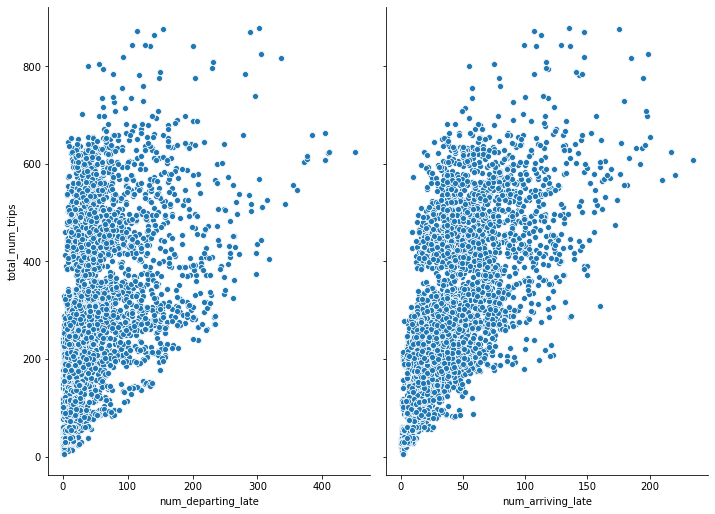

In [14]:
sns.pairplot(
    df,
    x_vars=['num_departing_late', 'num_arriving_late'],
    y_vars='total_num_trips',
    height=7,
    aspect=0.7
)

### Add additional statistics as new columns
We can add columns containing additional statistics concerning the proportion of time each route is late either departing or arriving by using the add_columns method for each route. 

Note the difference between how we added the two columns below and the same code in the chained_df file creation at the top of the notebook. In order to operate on the df that was in the process of being created in the call chain, we had to use join_apply with a lambda function instead of the add_columns method. Alternatively, we could have split the chain into two separate chains with the df being created in the first chain and the add_columns method being used in the second chain.

In [15]:
df_prop = (
    df.add_columns(
        prop_late_departures=df.num_departing_late / df.total_num_trips,
        prop_late_arrivals=df.num_arriving_late / df.total_num_trips
    )
)

df_prop.head(3)

,year,month,departure_station,arrival_station,journey_time_avg,total_num_trips,avg_delay_all_departing,avg_delay_all_arriving,num_departing_late,num_arriving_late,prop_late_departures,prop_late_arrivals
0,2017,9,PARIS EST,METZ,85.133779,299,0.752007,0.419844,15,17.0,0.050167,0.056856
1,2017,9,REIMS,PARIS EST,47.064516,218,1.263518,1.137558,10,23.0,0.045872,0.105505
2,2017,9,PARIS EST,STRASBOURG,116.234940,333,1.139257,1.586396,20,19.0,0.060060,0.057057
